## Generating the graphs

Here, we generate 1000 random walks on a fixed random graphs with 20 nodes and edge density 0.1. We keep the same start and goal node for each graph and each random walk. We then take each step in the random walk and extract the state (the index of the current node we are at), the action (the index of the next node chosen in the graph) and the returns-to-go (the negative sum of the number of steps left in our path).

In [419]:
import networkx as nx
import numpy as np
import random

# Set the random seed
random.seed(42)

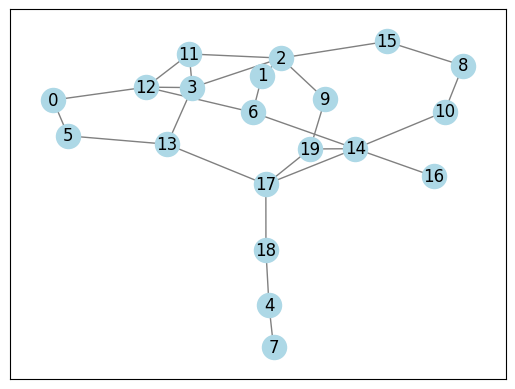

In [420]:
# Load fixed graph from pickle file
import pickle
import os

# Generate training sequences
num_graphs = 1000  # Number of random walks
num_nodes = 20  # Nodes in each graph
edge_prob = 0.1  # Edge probability
# start_node, goal_node = 0, 5  # Example start and goal nodes
max_steps = 10  # Maximum steps in each random walk

def generate_connected_graph(num_nodes, edge_prob):
    while True:
        graph = nx.erdos_renyi_graph(n=num_nodes, p=edge_prob, directed=False)
        if nx.is_connected(graph):
            return graph

path = 'fixed_graph.pkl'
if not os.path.exists(path):
    fixed_graph = generate_connected_graph(num_nodes, edge_prob)
    with open(path, 'wb') as f:
        pickle.dump(fixed_graph, f)

# Load the fixed graph from the pickle file
with open('fixed_graph.pkl', 'rb') as f:
    fixed_graph = pickle.load(f)

# Draw the fixed graph with networkx
nx.draw_networkx(fixed_graph, pos=nx.spring_layout(fixed_graph), node_color='lightblue', edge_color='grey')

In [421]:
def random_walk_with_returns(graph, start_node, goal_node, max_steps=10):
    current_node = start_node
    walk_data = []
    steps = 0

    while steps < max_steps:
        neighbors = list(graph.neighbors(current_node))
        next_node = random.choice(neighbors) if neighbors else current_node
        walk_data.append((current_node, next_node))
        current_node = next_node
        steps += 1
        if current_node == goal_node:
            #print("Goal reached")
            break

    return walk_data

def create_training_sequences(graph, num_walks, max_steps=10):
    training_sequences, walk_lengths = [], []
    for _ in range(num_walks):
        start_node = 8 #random.choice(list(graph.nodes)) # 12
        goal_node = 14 # or any other fixed goal node
        # while goal_node == start_node:
        #     start_node = random.choice(list(graph.nodes))
        walk_data = random_walk_with_returns(graph, start_node, goal_node, max_steps)

        # calculate RTG based on whether the goal is reached and the number of steps taken
        reached_goal = walk_data[-1][1] == goal_node
        total_rtg = -len(walk_data) if reached_goal else -999

        walk_lengths.append(len(walk_data))

        for i in range(1, len(walk_data) + 1):
            sequence = [(total_rtg + i - 1, s, a) for i, (s, a) in enumerate(walk_data[:i])]
            sequence = [(total_rtg, start_node, start_node)] + sequence  # Prepend with initial state
            training_sequences.append(sequence)

    return training_sequences, walk_lengths

num_graphs = 1000
training_sequences, walk_lengths = create_training_sequences(fixed_graph, num_graphs, max_steps)
validation_sequences, _ = create_training_sequences(fixed_graph, int(num_graphs*0.1), max_steps)

In [422]:
len(training_sequences)

6750

Examining one of these training sequences:

In [423]:
# get a random training sequence
random.choice(training_sequences)

[(-2, 8, 8), (-3, 8, 10)]

In [424]:
training_sequences[1006]

[(-999, 8, 8), (-1000, 8, 15)]

In [425]:
training_sequences[1007], training_sequences[1008], training_sequences[1009]

([(-999, 8, 8), (-1000, 8, 15), (-999, 15, 8)],
 [(-999, 8, 8), (-1000, 8, 15), (-999, 15, 8), (-998, 8, 15)],
 [(-999, 8, 8), (-1000, 8, 15), (-999, 15, 8), (-998, 8, 15), (-997, 15, 8)])

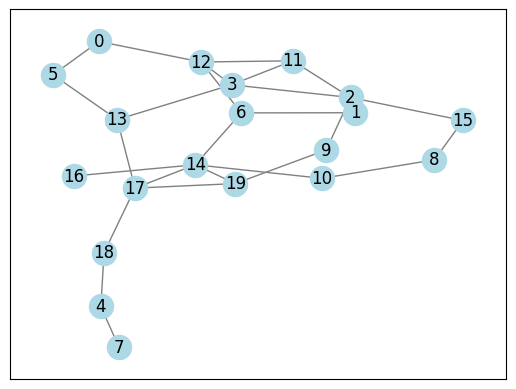

In [426]:
nx.draw_networkx(fixed_graph, pos=nx.spring_layout(fixed_graph), node_color='lightblue', edge_color='grey')

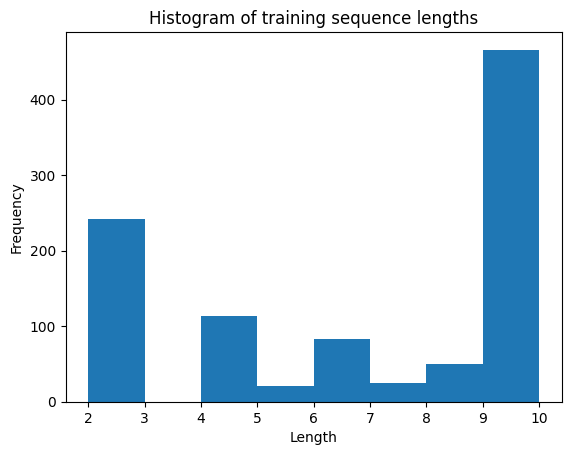

In [427]:
# plot a histogram of the lengths of the training sequences
import matplotlib.pyplot as plt

plt.hist(walk_lengths, bins=range(min(walk_lengths), max(walk_lengths) + 1))
plt.title('Histogram of training sequence lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [428]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

class DecisionTransformer(nn.Module):
    def __init__(self, state_dim, action_dim, embed_dim, num_layers, num_heads, max_steps):
        super(DecisionTransformer, self).__init__()
        self.embed_dim = embed_dim
        self.embed_s = nn.Embedding(state_dim+1, embed_dim)
        self.embed_a = nn.Embedding(action_dim+1, embed_dim)
        self.embed_R = nn.Linear(1, embed_dim)  
        self.embed_t = nn.Embedding(max_steps+2, embed_dim)

        self.encoder_layers = nn.TransformerEncoderLayer(d_model=3*embed_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layers, num_layers=num_layers)

        self.pred_a = nn.Linear(3*embed_dim, action_dim+1)

    def forward(self, R, s, a, t, attention_mask):

        R_emb = self.embed_R(R.unsqueeze(-1))
        s_emb = self.embed_s(s)
        a_emb = self.embed_a(a)
        t_emb = self.embed_t(t)

        # stack embeddings and add timesteps embeddings to each
        stacked_embeds = torch.stack((R_emb, s_emb, a_emb), dim=2)  # New shape: [batch, seq_len, 3, embed_dim]
        t_emb = t_emb.unsqueeze(2)  # New shape: [batch, seq_len, 1, embed_dim]
        
        # repeat t_emb to match the shape of stacked_embeds and add
        t_emb = t_emb.expand(-1, -1, 3, -1)
        input_embeds = stacked_embeds + t_emb  # Broadcasting addition

        # reshape for transformer and permute to match expected shape (seq_len, batch, dim)
        input_embeds = input_embeds.reshape(-1, stacked_embeds.shape[1], 3 * self.embed_dim).permute(1, 0, 2)

        transformer_output = self.transformer_encoder(input_embeds, src_key_padding_mask=attention_mask)
        action_logits = self.pred_a(transformer_output[-1])

        return action_logits

class DecisionTransformerDataset(Dataset):
    def __init__(self, sequences, max_length):
        self.sequences = sequences
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        R, s, a = zip(*sequence)

        # padding logic (assuming 20 is a valid padding index)
        padding_length = self.max_length - len(R) + 1
        R_padded = F.pad(torch.tensor(R, dtype=torch.float32), (0, padding_length))
        s_padded = F.pad(torch.tensor(s, dtype=torch.long), (0, padding_length), value=20)
        a_padded = F.pad(torch.tensor(a[:-1], dtype=torch.long), (0, padding_length + 1), value=20)
        t = torch.arange(1, len(a_padded) + 1)

        target_action = a[-1]

        # Create attention mask with 'False' for actual data and 'True' for padding
        actual_length = len(R)
        attention_mask = [False] * actual_length + [True] * (self.max_length+1 - actual_length)
        attention_mask = torch.tensor(attention_mask, dtype=torch.bool)

        return (R_padded, s_padded, a_padded, t, attention_mask), target_action

batch_size = 1024
max_sequence_length = 10  # Assuming the maximum length of sequences is 10
dataset = DecisionTransformerDataset(training_sequences, max_sequence_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_dataset = DecisionTransformerDataset(validation_sequences, max_sequence_length)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Model parameters
state_dim = 20  # number of nodes (plus 1 for padding index)
action_dim = 20  # same as state_dim (plus 1 for padding index)
embed_dim = 128  # embedding dimension
num_layers = 1  # number of transformer encoder layers
num_heads = 4   # number of heads in multiheadattention models
max_steps = 10  # maximum number of steps in a sequence (plus 1 for padding index)

# Instantiate the model
model = DecisionTransformer(state_dim, action_dim, embed_dim, num_layers, num_heads, max_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# for (R, s, a, t), target_action in dataloader:

#     # Add checks for specific ranges if necessary
#     if s.max().item() > state_dim or a.max().item() > action_dim:
#         raise ValueError("State or action index out of range")

# Training loop
num_epochs = 50 

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    for (R, s, a, t, attention_mask), target_action in dataloader:
        action_logits = model(R, s, a, t, attention_mask)
        # print(f"Chosen action: {torch.argmax(action_logits, dim=1)}")
        # print(f"Target action: {target_action}")
        loss = criterion(action_logits, target_action)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 5 == 0:
        # Evaluate on validation set
        model.eval()
        val_loss = 0
        for (R, s, a, t, attention_mask), target_action in val_dataloader:
            action_logits = model(R, s, a, t, attention_mask)
            loss = criterion(action_logits, target_action)
            val_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss / len(dataloader):.2f}, Val Loss: {val_loss / len(val_dataloader):.2f}")

 10%|█         | 5/50 [00:12<01:52,  2.50s/it]

Epoch [5/50], Train Loss: 1.63, Val Loss: 1.64


 20%|██        | 10/50 [00:25<01:41,  2.53s/it]

Epoch [10/50], Train Loss: 1.56, Val Loss: 1.59


 30%|███       | 15/50 [00:37<01:29,  2.57s/it]

Epoch [15/50], Train Loss: 1.54, Val Loss: 1.57


 40%|████      | 20/50 [00:50<01:17,  2.57s/it]

Epoch [20/50], Train Loss: 1.54, Val Loss: 1.57


 44%|████▍     | 22/50 [00:56<01:11,  2.57s/it]


KeyboardInterrupt: 

## Generation

In [404]:
import torch
import torch.nn.functional as F
import networkx as nx

def generate_path(model, graph, start_node, goal_node, good=True, max_steps=10, print_output=False):
    # calculate initial return-to-go (RtG) as the shortest path length (or a large number)
    if nx.has_path(graph, start_node, goal_node):
        initial_rtg = -nx.shortest_path_length(graph, start_node, goal_node)
    else:
        # raise an exception if the goal node is unreachable
        raise ValueError("Goal node is unreachable")

    # initialise sequence with start node and high initial RtG
    sequence = [(initial_rtg, start_node, start_node)]
    current_node = start_node
    attention_mask = [False]

    for step in range(max_steps):
        
        # convert current sequence to tensors and add batch dimension
        R, s, a = zip(*sequence)
        R_tensor = torch.tensor([R], dtype=torch.float32)
        s_tensor = torch.tensor([s], dtype=torch.long)
        a_tensor = torch.tensor([a], dtype=torch.long)
        t_tensor = torch.arange(len(R)).unsqueeze(0)
        attention_mask_tensor = torch.tensor([attention_mask], dtype=torch.bool)

        # print the inputs to the model for debugging
        if print_output:
            print(f"Step {step+1} RtG: {R_tensor.squeeze().numpy()}")
            print(f"Step {step+1} state: {s_tensor.squeeze().numpy()}")
            print(f"Step {step+1} action: {a_tensor.squeeze().numpy()}")
            print(f"Step {step+1} timesteps: {t_tensor.squeeze().numpy()}")
            print(f"Step {step+1} attention mask: {attention_mask_tensor.squeeze().numpy()}")
            print()

        # Predict next action
        with torch.no_grad():
            action_logits = model(R_tensor, s_tensor, a_tensor, t_tensor, attention_mask_tensor)
            # zero out the logits for the current node (force the model to move)
            action_logits[0, current_node] = -torch.inf
            next_node = torch.argmax(action_logits, dim=-1).item()
            if print_output: print(f"Step {step+1} next node: {next_node}")

        # check if the next node is a neighbor of the current node
        if next_node in graph.neighbors(current_node):
            if print_output: print(f"Step {step+1} next node in neighbours (next node): {next_node}, neighbours: {list(graph.neighbors(current_node))})")
            current_node = next_node
        else:
            # if next_node is not a neighbor, stay at the current node
            if print_output: print(f"Step {step+1} staying at current node: {current_node} ( we chose {next_node} but it is not a neighbour of {current_node}))")
            next_node = current_node  # Stay at the current node

        # Calculate the return-to-go (RtG) for the next step
        if current_node == goal_node:
            # break the loop immediately if goal node is reached
            # and append the goal node to the sequence
            sequence.append((0, current_node, current_node))
            break
        elif nx.has_path(graph, source=current_node, target=goal_node):
            if good: next_rtg = -nx.shortest_path_length(graph, current_node, goal_node)
            else: next_rtg = -999
        else: next_rtg = -999

        sequence.append((next_rtg, current_node, next_node))
        attention_mask.append(False)
        if current_node == goal_node:
            break

    generated_path = [a for _, _, a in sequence]
    shortest_path = nx.shortest_path(graph, start_node, goal_node) if nx.has_path(graph, start_node, goal_node) else "No path available"

    return generated_path, shortest_path

In [405]:
# these need to be the same as the ones we used to train the model
start_node = 8 #random.choice(list(fixed_graph.nodes))
goal_node = 9

with open('fixed_graph.pkl', 'rb') as f:
    fixed_graph = pickle.load(f)

generated_path, shortest_path = generate_path(model, fixed_graph, start_node, goal_node, good=True, max_steps=10, print_output=True)
print("Generated Path by Model:", generated_path)
print("Shortest Path (NetworkX):", shortest_path)

Step 1 RtG: -3.0
Step 1 state: 8
Step 1 action: 8
Step 1 timesteps: 0
Step 1 attention mask: False

Step 1 next node: 1
Step 1 next node in neighbours (next node): 1, neighbours: [0, 1, 3])
Step 2 RtG: [-3. -3.]
Step 2 state: [8 1]
Step 2 action: [8 1]
Step 2 timesteps: [0 1]
Step 2 attention mask: [False False]

Step 2 next node: 3
Step 2 next node in neighbours (next node): 3, neighbours: [0, 2, 3, 8])
Step 3 RtG: [-3. -3. -2.]
Step 3 state: [8 1 3]
Step 3 action: [8 1 3]
Step 3 timesteps: [0 1 2]
Step 3 attention mask: [False False False]

Step 3 next node: 0
Step 3 staying at current node: 3 ( we chose 0 but it is not a neighbour of 3))
Step 4 RtG: [-3. -3. -2. -2.]
Step 4 state: [8 1 3 3]
Step 4 action: [8 1 3 3]
Step 4 timesteps: [0 1 2 3]
Step 4 attention mask: [False False False False]

Step 4 next node: 0
Step 4 staying at current node: 3 ( we chose 0 but it is not a neighbour of 3))
Step 5 RtG: [-3. -3. -2. -2. -2.]
Step 5 state: [8 1 3 3 3]
Step 5 action: [8 1 3 3 3]
Step 5 

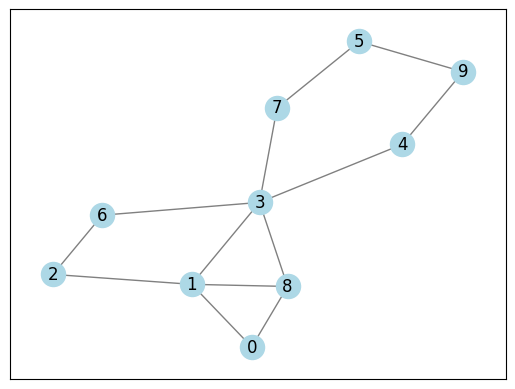

In [406]:
# Print the fixed graph
nx.draw_networkx(fixed_graph, pos=nx.spring_layout(fixed_graph), node_color='lightblue', edge_color='grey')

In [407]:
import random

def random_walk(graph, start_node, goal_node, max_steps=10):
    current_node = start_node
    path = [current_node]

    while len(path) < max_steps and current_node != goal_node:
        neighbors = list(graph.neighbors(current_node))
        if neighbors:
            current_node = random.choice(neighbors)
            path.append(current_node)
        else:
            break  # Break if a node has no neighbors

    return path

def compare_path_lengths(model, graph, goal_node, n, max_steps=10, good=True, random_start=True):
    path_lengths = {
        "transformer_path_lengths": [],
        "shortest_path_lengths": [],
        "random_walk_lengths": []  # New key for random walk path lengths
    }

    for _ in range(n):

        # Choose a random start node
        start_node = 12 if random_start==False else random.choice(list(graph.nodes))

        # Generate path using the transformer model
        transformer_path, shortest_path = generate_path(model, graph, start_node, goal_node, good, max_steps)

        # Generate a random walk path
        random_walk_path = random_walk(graph, start_node, goal_node, max_steps)

        # Record the lengths of the paths
        path_lengths["transformer_path_lengths"].append(len(transformer_path))
        path_lengths["shortest_path_lengths"].append(len(shortest_path))
        path_lengths["random_walk_lengths"].append(len(random_walk_path))

    return path_lengths

with open('fixed_graph.pkl', 'rb') as f:
    fixed_graph = pickle.load(f)

Let's plot the histogram of path lengths based on good and bad conditioning. Let's start with bad conditioning:

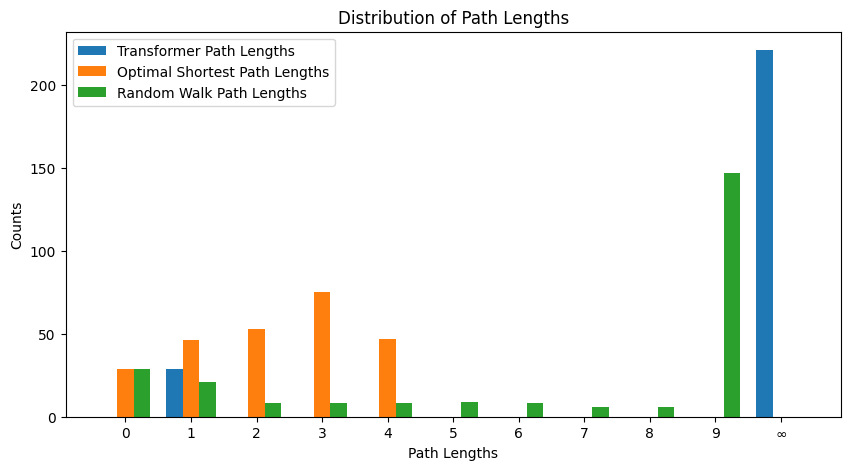

In [408]:
import matplotlib.pyplot as plt
import numpy as np

def plot_histogram_path_lengths(n, good):

    path_lengths = compare_path_lengths(model, fixed_graph, goal_node, n, max_steps=10, good=good)

    # Data Preparation
    transformer_lengths = path_lengths['transformer_path_lengths']
    shortest_lengths = path_lengths['shortest_path_lengths']
    random_walk_lengths = path_lengths['random_walk_lengths']

    # Count the occurrences of each path length
    transformer_length_counts = {length: transformer_lengths.count(length) for length in set(transformer_lengths)}
    shortest_length_counts = {length: shortest_lengths.count(length) for length in set(shortest_lengths)}
    random_walk_length_counts = {length: random_walk_lengths.count(length) for length in set(random_walk_lengths)}

    # Ensure both dictionaries have the same keys
    all_lengths = set(transformer_length_counts.keys()).union(shortest_length_counts.keys()).union(random_walk_length_counts.keys())
    for length in all_lengths:
        transformer_length_counts.setdefault(length, 0)
        shortest_length_counts.setdefault(length, 0)
        random_walk_length_counts.setdefault(length, 0)

    # Sorting keys and values for plotting
    sorted_lengths = sorted(all_lengths)
    transformer_counts = [transformer_length_counts[length] for length in sorted_lengths]
    shortest_counts = [shortest_length_counts[length] for length in sorted_lengths]
    random_walk_counts = [random_walk_length_counts[length] for length in sorted_lengths]

    # Plotting
    bar_width = 0.25  # Adjusted width to accommodate 3 bars
    index = np.arange(len(sorted_lengths))

    fig, ax = plt.subplots(figsize=(10, 5))
    bar1 = ax.bar(index, transformer_counts, bar_width, label='Transformer Path Lengths')
    bar2 = ax.bar(index + bar_width, shortest_counts, bar_width, label='Optimal Shortest Path Lengths')
    bar3 = ax.bar(index + 2 * bar_width, random_walk_counts, bar_width, label='Random Walk Path Lengths')

    ax.set_xlabel('Path Lengths')
    ax.set_ylabel('Counts')
    ax.set_title('Distribution of Path Lengths')
    ax.set_xticks(index + bar_width)  # Adjusting the xticks to be in the middle of the group of bars
    ax.set_xticklabels(sorted_lengths)
    # Make the last ticklabel infinity
    xticklabels = [str(int(label)) for label in ax.get_xticks()]
    xticklabels[-1] = r'$\infty$'
    ax.set_xticklabels(xticklabels)
    ax.legend()

    plt.show()

n = 250
good = False
plot_histogram_path_lengths(n, good)

So the transformer never reaches the goal, which is good, because we're conditioning on a reward of -999. And with good conditioning:

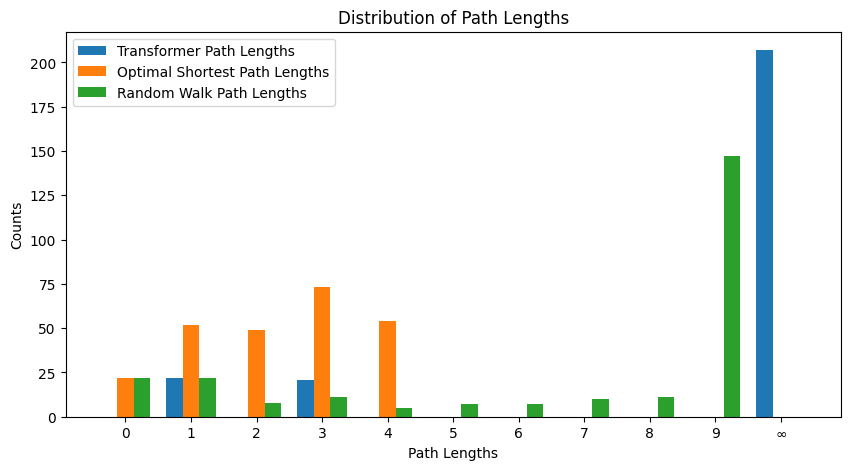

In [409]:
good = True
plot_histogram_path_lengths(n, good)

We always reach the goal! Good. 

The next job is to train the model with a variable start node (keeping the goal node fixed) and figure out why it's not working as well.

## Training the model with a variable start node

In [352]:
def random_walk_with_returns(graph, start_node, goal_node, max_steps=10):
    current_node = start_node
    walk_data = []
    steps = 0

    while steps < max_steps:
        neighbors = list(graph.neighbors(current_node))
        next_node = random.choice(neighbors) if neighbors else current_node
        walk_data.append((current_node, next_node))
        current_node = next_node
        steps += 1
        if current_node == goal_node:
            #print("Goal reached")
            break

    return walk_data

def create_training_sequences(graph, num_walks, max_steps=10):
    training_sequences, walk_lengths = [], []
    for _ in range(num_walks):
        start_node = random.choice(list(graph.nodes)) # 12
        goal_node = 10  # or any other fixed goal node
        # while goal_node == start_node:
        #     start_node = random.choice(list(graph.nodes))
        walk_data = random_walk_with_returns(graph, start_node, goal_node, max_steps)

        # calculate RTG based on whether the goal is reached and the number of steps taken
        reached_goal = walk_data[-1][1] == goal_node
        total_rtg = -len(walk_data) if reached_goal else -999

        walk_lengths.append(len(walk_data))

        for i in range(1, len(walk_data) + 1):
            sequence = [(total_rtg + i - 1, s, a) for i, (s, a) in enumerate(walk_data[:i])]
            sequence = [(total_rtg, start_node, start_node)] + sequence  # Prepend with initial state
            training_sequences.append(sequence)

    return training_sequences, walk_lengths

num_graphs = 1000
training_sequences, walk_lengths = create_training_sequences(fixed_graph, num_graphs, max_steps)
validation_sequences, _ = create_training_sequences(fixed_graph, int(num_graphs*0.1), max_steps)

In [355]:
batch_size = 1024
max_sequence_length = 10  # Assuming the maximum length of sequences is 10
dataset = DecisionTransformerDataset(training_sequences, max_sequence_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_dataset = DecisionTransformerDataset(validation_sequences, max_sequence_length)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# model parameters
state_dim = 20  # number of nodes (plus 1 for padding index)
action_dim = 20  # same as state_dim (plus 1 for padding index)
embed_dim = 128  # embedding dimension
num_layers = 1  # number of transformer encoder layers
num_heads = 4   # number of heads in multiheadattention models
max_steps = 10  # maximum number of steps in a sequence (plus 1 for padding index)

# instantiate the model
model = DecisionTransformer(state_dim, action_dim, embed_dim, num_layers, num_heads, max_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# training loop
num_epochs = 50 

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    for (R, s, a, t, attention_mask), target_action in dataloader:
        action_logits = model(R, s, a, t, attention_mask)
        # print(f"Chosen action: {torch.argmax(action_logits, dim=1)}")
        # print(f"Target action: {target_action}")
        loss = criterion(action_logits, target_action)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 5 == 0:
        # Evaluate on validation set
        model.eval()
        val_loss = 0
        for (R, s, a, t, attention_mask), target_action in val_dataloader:
            action_logits = model(R, s, a, t, attention_mask)
            loss = criterion(action_logits, target_action)
            val_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss / len(dataloader):.2f}, Val Loss: {val_loss / len(val_dataloader):.2f}")

 10%|█         | 5/50 [00:17<02:35,  3.46s/it]

Epoch [5/50], Train Loss: 2.65, Val Loss: 2.71


 20%|██        | 10/50 [00:34<02:17,  3.44s/it]

Epoch [10/50], Train Loss: 1.80, Val Loss: 1.63


 30%|███       | 15/50 [00:51<02:01,  3.48s/it]

Epoch [15/50], Train Loss: 1.06, Val Loss: 0.98


 40%|████      | 20/50 [01:08<01:43,  3.46s/it]

Epoch [20/50], Train Loss: 0.98, Val Loss: 0.96


 50%|█████     | 25/50 [01:26<01:27,  3.50s/it]

Epoch [25/50], Train Loss: 0.96, Val Loss: 0.94


 60%|██████    | 30/50 [01:43<01:09,  3.47s/it]

Epoch [30/50], Train Loss: 0.94, Val Loss: 0.92


 70%|███████   | 35/50 [02:01<00:52,  3.49s/it]

Epoch [35/50], Train Loss: 0.94, Val Loss: 0.92


 80%|████████  | 40/50 [02:18<00:34,  3.49s/it]

Epoch [40/50], Train Loss: 0.94, Val Loss: 0.94


 90%|█████████ | 45/50 [02:35<00:17,  3.49s/it]

Epoch [45/50], Train Loss: 0.94, Val Loss: 0.93


100%|██████████| 50/50 [02:53<00:00,  3.46s/it]

Epoch [50/50], Train Loss: 0.92, Val Loss: 0.95


In [356]:
# these need to be the same as the ones we used to train the model
start_node = random.choice(list(fixed_graph.nodes))
goal_node = 8

with open('fixed_graph.pkl', 'rb') as f:
    fixed_graph = pickle.load(f)

generated_path, shortest_path = generate_path(model, fixed_graph, start_node, goal_node, good=True, max_steps=10, print_output=True)
print("Generated Path by Model:", generated_path)
print("Shortest Path (NetworkX):", shortest_path)

Step 1 RtG: -3.0
Step 1 state: 6
Step 1 action: 6
Step 1 timesteps: 0
Step 1 attention mask: False

Step 1 next node: 12
Step 1 next node in neighbours (next node): 12, neighbours: [1, 3, 12])
Step 2 RtG: [-3. -2.]
Step 2 state: [ 6 12]
Step 2 action: [ 6 12]
Step 2 timesteps: [0 1]
Step 2 attention mask: [False False]

Step 2 next node: 13
Step 2 next node in neighbours (next node): 13, neighbours: [4, 5, 6, 13])
Step 3 RtG: [-3. -2. -1.]
Step 3 state: [ 6 12 13]
Step 3 action: [ 6 12 13]
Step 3 timesteps: [0 1 2]
Step 3 attention mask: [False False False]

Step 3 next node: 15
Step 3 next node in neighbours (next node): 15, neighbours: [0, 8, 12, 15, 18])
Step 4 RtG: [-3. -2. -1. -2.]
Step 4 state: [ 6 12 13 15]
Step 4 action: [ 6 12 13 15]
Step 4 timesteps: [0 1 2 3]
Step 4 attention mask: [False False False False]

Step 4 next node: 0
Step 4 staying at current node: 15 ( we chose 0 but it is not a neighbour of 15))
Step 5 RtG: [-3. -2. -1. -2. -2.]
Step 5 state: [ 6 12 13 15 15]
St

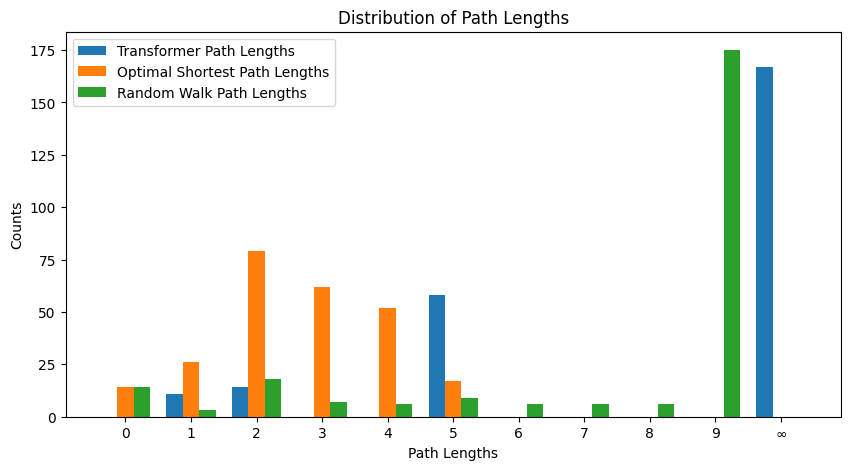

In [359]:
n = 250
good = True
plot_histogram_path_lengths(n, good)

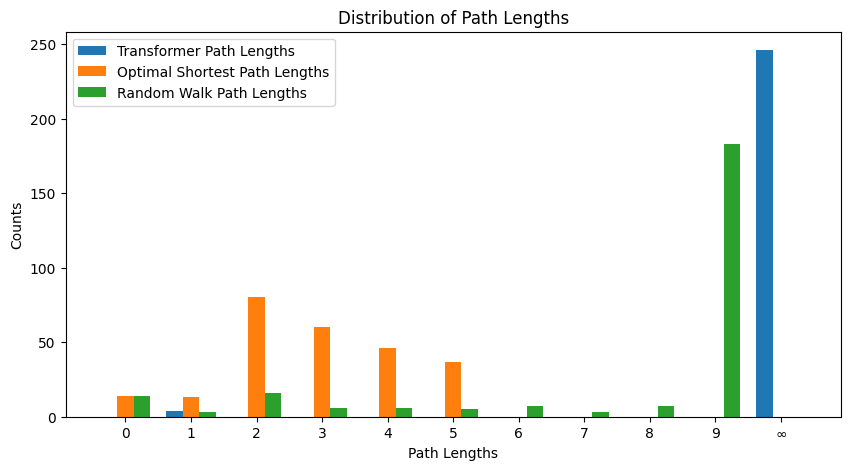

In [360]:
n = 250
good = False
plot_histogram_path_lengths(n, good)